# Measuring embedding models performance for restaurant similarity search

Our goal is to identify the top-performing embedding model for retrieving restaurants that best match a search query. By generating vectors for both search queries and restaurant descriptions, we’ll measure their cosine similarity to evaluate performance. We’ll also fine-tune cosine similarity thresholds to strike the ideal balance between quality and quantity, ensuring the results are both accurate and comprehensive.

## Understanding metrics

Before diving deeper, let’s take a moment to clarify the metrics we’ll use to evaluate our models. These metrics — **precision**, **recall**, and a derived metric called **F-score** — are key to understanding performance.

If you’re already familiar with these concepts, feel free to skip ahead. For the rest of us, let’s break it down with a simple analogy:

Imagine you’re searching for Italian restaurants, and the algorithm gives you 10 results.
- **Precision** measures accuracy. How many of the 10 results are actually Italian restaurants? If 8 out of 10 are correct, your precision is 80%.
- **Recall** measures coverage. Out of all the Italian restaurants in the database, how many did the algorithm find? If there are 9 Italian restaurants total and the search returns 8 of them, your recall is about 89% (8 out of 9).

Together, these metrics help us assess the balance between quality (precision) and completeness (recall).

### But you mentioned a third metric...F-score?

Sometimes, we want a single metric to summarize both **precision** and **recall**, especially when we need to balance the two. This is where the **F-score** comes in. It combines precision and recall into one number by calculating their harmonic mean.

For example, if your precision is 80% and recall is 89%, the F1-score would be approximately 84%. ([How to calculate F1](https://en.wikipedia.org/wiki/F-score))

```
F1 = 2*(0.8*0.89)/(0.8+0.89) // 0.84
```

**Note**: The F1-score assumes that precision and recall are equally important. However, in some cases, you might prioritize one over the other, for example:
- If precision is more critical (e.g, reducing false positives in a medical diagnosis system), you may want to place more weight on precision.
- If recall is more important (e.g., ensuring no relevant results are missed in a search engine), you may want to prioritize recall instead.

To adjust this balance, you can use the F-beta score, a generalization of the F1-score. ([F-beta formula](https://en.wikipedia.org/wiki/F-score#:~:text=.-,F%CE%B2%20score,-%5Bedit%5D))
Where:
- beta < 1: Places more emphasis on precision.
- beta > 1: Places more emphasis on recall.
- beta = 1: Balances precision and recall equally (this is the F1-score).

Let's get started. We're going to import everything that we need for this experiment.

In [1]:
from llama_cpp import Llama
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, fbeta_score
import contextlib
import io
import sys
import matplotlib.pyplot as plt

## Load up restaurant data

To get started, I’ve provided some sample data from my dataset, conveniently saved as a CSV file.
All we need to do is load it up and get to work!

In [2]:
pd.set_option('display.max_colwidth', 400)
places_df = pd.read_csv('places.csv')

places_df.head()

,id,description,name
0,1885,"Authentic Mexican tacos, prepared by Mexican chefs, now available on Crescent Street and St-Denis Street in Montreal.",Tacos Victor Crescent
1,6250,"La Prep offers a wide variety of fresh, made-to-order meals daily. From pastries to salads and sandwiches, all items are prepared in-house with high-quality ingredients. Enjoy a fresh, welcoming atmosphere.",La Prep
2,6797,9th-floor Montreal restaurant with a seaside-themed terrace offering stunning downtown views and H3-signature cuisine & cocktails.,Terrasse Alizé
3,1937,"Unfussy Italian cafe & coffee shop with WiFi, sports on TV & a menu of pizza & pastas until late.",Expresso Bar
4,6306,"Vintage design bar & restaurant with salads, sandwiches, burgers & amuse bouches on the menu.",LOCAL75 Bistro Pub


> Most of these restaurant descriptions were either sourced from Google or generated using Gemini, leveraging the metadata we had for each restaurant.

## Writing test cases

To effectively evaluate our system, we need to design search queries and identify which restaurants should be retrieved for each query. These queries mimic real-world searches to ensure they align closely with the restaurants in our dataset. By doing this, we can simulate user interactions and assess the system’s performance accurately.

In addition to defining test cases, we’ll also specify the models we want to compare. For this experiment, I’ve selected a variety of all-MiniLM models at different quantization levels and a model from Nomic AI. This will allow us to assess performance across a range of architectures and configurations.

In [173]:
test_cases = [
    {
        "query": "Looking for a place with authentic Mexican food.",
        "expected_restaurants": [
            1885,
            7164
        ]
    },
    {
        "query": "Find restaurants with rotisserie chicken",
        "expected_restaurants": [
            3536,
            2439,
            3322,
        ]
    },
    {
        "query": "Find casual spots with burgers and fries.",
        "expected_restaurants": [
            3191,
            170,
            5330,
            2439,
            1386
        ]
    },
    {
        "query": "Looking for sushi places offering poke bowls.",
        "expected_restaurants": [
            4972,
            6397,
            1097,
            7302,
            1789
        ]
    },
    {
        "query": "Find upscale places with cocktails and unique dishes.",
        "expected_restaurants": [
            6797,
            7462,
            3523,
            6102,
            7164,
            3036,
            7230,
            4593
        ]
    },
    {
        "query": "Where can I find a great brunch spot?",
        "expected_restaurants": [
            3289,
            3966,
            5568
        ]
    },
    {
        "query": "Places with sandwiches",
        "expected_restaurants": [
            6250,
            6306,
            1919,
            170,
            6065,
            2231,
            4749,
            5467,
        ]
    }
]

models = [
    {
        "name": "All-MiniLM-L6-v2 Q4_K_S",
        "repo_id": "second-state/All-MiniLM-L6-v2-Embedding-GGUF",
        "filename": "*Q4_K_S.gguf"
    },
    {
        "name": "All-MiniLM-L6-v2 Q4_K_M",
        "repo_id": "second-state/All-MiniLM-L6-v2-Embedding-GGUF",
        "filename": "*Q4_K_M.gguf"
    },
    {
        "name": "All-MiniLM-L6-v2 Q5_K_M",
        "repo_id": "second-state/All-MiniLM-L6-v2-Embedding-GGUF",
        "filename": "*Q5_K_M.gguf"
    },
    {
        "name": "All-MiniLM-L12-v2 Q4_K_M",
        "repo_id": "sheldonrobinson/all-MiniLM-L12-v2-Q4_K_M-GGUF",
        "filename": "*q4_k_m.gguf"
    },
    {
        "name": "nomic-embed-text Q5_K_M",
        "repo_id": "nomic-ai/nomic-embed-text-v1.5-GGUF",
        "filename": "*Q5_K_M.gguf",

        # These are specifics to this model
        "query_prefix": "search_query: ",
        "document_prefix": "search_document: "
    },
]

Now, let’s build a set of helper functions to handle the heavy lifting for our experiment. I’ll include clear documentation for each function to help you understand its purpose and functionality.

In [172]:
def load_model(repo_id, filename, **kwargs):
    """
    Simple wrapper around `from_pretrained`. llama-cpp will take care of downloading the model using huggingface-hub.
    You can managed the models locally using their CLI.
    """
    return Llama.from_pretrained(
            repo_id=repo_id,
            filename=filename,
            verbose=False,
            embedding=True,
            n_gpu_layers=1,
            **kwargs
        )

def load_model_without_warning(repo_id, filename, **kwargs):
    """
    Wrapper around `load_model` which silences some warnings about unsupported kernels. 
    We can safely ignore these warnings as it really pertains to the hardware this notebook is running on.
    """
    buffer = io.StringIO()
    with contextlib.redirect_stderr(buffer):
        llm = load_model(repo_id, filename, **kwargs)

    captured_output = buffer.getvalue().splitlines()

    # llama-cpp writes directly to stderr/stdout but it keeps printing warning about messages that can be ignored such as 
    # ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
    for line in captured_output:
        if "ggml_metal_init: skipping kernel_" in line:
            continue
        else:
            # Print back anything that's not the kernel warning
            print(line, file=sys.stderr)

    return llm

def normalize_vectors(vectors):
    """
    Normalize vectors using the Euclidean norm.
    Each vector will have a magnitude of 1.
    This makes sure cosine similarity doesn't get skewed towards vectors with a big magnitude as we only care about vector direction.
    """
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / norms


def generate_embeddings(llm, docs, prefix=""):
    """
    Generate embeddings using llama-cpp and the current loaded model.
    Note: some embedding models require to add a task prefix in front of the document to embed. e.g `search_document: {doc}`
    """
    docs = [f"{prefix}{doc}" for doc in docs]
    response = llm.create_embedding(docs)
    return normalize_vectors([k['embedding'] for k in response['data']])


def generate_model_results(
    llm,
    places,
    test_cases,
    document_prefix = "",
    query_prefix = "",
):
    """
    Generate a dataframe with various metadata about each place, as well as a cosine similarity score given the current query and each restaurant.
    We will generate various metrics from this dataframe.
    """
    # Shape (50,384)
    embeddings = generate_embeddings(llm, places['description'].tolist(), document_prefix)

    results = []
    for case in test_cases:
        query = case["query"]
        expected_restaurants = case["expected_restaurants"]

        # Shape (1,384)
        query_embedding = generate_embeddings(llm, [query], query_prefix)

        # Shape (1,50)
        cosine_similarities = cosine_similarity(query_embedding, embeddings)[0]

        # Shape (1,50)
        # Normalizing a [-1,1] range into [0,1] score whereas 1 is completely identical.
        cosine_scores = (cosine_similarities + 1) / 2

        for idx, score in enumerate(cosine_scores):
            results.append({
                "query": query,
                "expected_in_search": places.iloc[idx]['id'] in expected_restaurants,
                "description": places.iloc[idx]['description'],
                "restaurant_id": places.iloc[idx]['id'],
                "score": score
            })

    return pd.DataFrame(results)

def analyze_thresholds(test_cases, results_df, f_beta=1, thresholds=np.linspace(0, 1, 50)):
    """
    Evaluates precision, recall, and F-beta for each search query at various cosine similarity thresholds.
    Returns an analysis that includes the most optimal threshold, which maximizes the F-beta score based on the chosen weighting.

    Note: You can specify a custom F-beta value to adjust the balance between precision and recall:
	•	F-beta < 1: Emphasizes precision.
	•	F-beta > 1: Emphasizes recall.
    """
    threshold_analysis = {}
    
    # Group results by query
    grouped_results = results_df.groupby('query')
    
    for query, group in grouped_results:
        # Find corresponding test case
        test_case = next(tc for tc in test_cases if tc['query'] == query)
        
        fbeta_scores = []
        precisions = []
        recalls = []
        
        # Test each threshold
        for threshold in thresholds:
            y_true = group['expected_in_search']
    
            # Note: This can yield only `False` value if the threshold is too high, e.g 1.00
            # As a result, sklearn can complain if it doesn't see some labels in `y_pred` when calculating metrics.
            y_pred = group['score'] >= threshold
    
            precision = precision_score(y_true, y_pred, zero_division=np.nan)
            recall = recall_score(y_true, y_pred)
            fbeta = fbeta_score(y_true, y_pred, beta=f_beta)
            
            fbeta_scores.append(fbeta)
            precisions.append(precision)
            recalls.append(recall)
        
        # Find optimal threshold
        best_idx = np.argmax(fbeta_scores)
        optimal_threshold = thresholds[best_idx]
        
        threshold_analysis[query] = {
            'optimal_threshold': optimal_threshold,
            'fbeta': {
                'value': fbeta_scores[best_idx],
                'precision_at_value': precisions[best_idx],
                'recall_at_value': recalls[best_idx]
            }
        }
    
    return threshold_analysis

## Measuring Performance

Now it’s time to evaluate each query against all the models and measure their performance. For this, we’ll:
- 1. Load each model: Loop through all selected models, initialize them and generate embeddings.
- 2. Create the necessary dataframes: Prepare the data for analysis, including cosine similarity scores for each query and restaurant pairing.
- 3. Perform threshold analysis: Identify the optimal cosine similarity thresholds yielding the best f-beta score.
- 4. Prepare reporting data: Generate a consolidated dataset that summarizes the results, ready for reporting and comparison.

This should give you a good overview at the performance of each model for individual queries.


In [175]:
rows = []

for model_info in models:
    llm = load_model_without_warning(repo_id=model_info["repo_id"], filename=model_info["filename"])
    query_prefix = model_info.get("query_prefix", "")
    document_prefix = model_info.get("document_prefix", "")
    results_df = generate_model_results(llm, places_df, test_cases, document_prefix, query_prefix)
    threshold_analysis = analyze_thresholds(test_cases, results_df, f_beta=1)

    for query, analysis in threshold_analysis.items():
        rows.append({
            "model_name": model_info["name"],
            "query": query,
            "best_threshold": analysis["optimal_threshold"],
            "best_fbeta": analysis["fbeta"]["value"],
            "recall_from_fbeta": analysis["fbeta"]["recall_at_value"],
            "precision_from_fbeta": analysis["fbeta"]["precision_at_value"],
        })

df = pd.DataFrame(rows)
df.head()

llama_new_context_with_model: n_ctx_per_seq (512) < n_ctx_train (2048) -- the full capacity of the model will not be utilized


,model_name,query,best_threshold,best_fbeta,recall_from_fbeta,precision_from_fbeta
0,All-MiniLM-L6-v2 Q4_K_S,Find casual spots with burgers and fries.,0.714286,0.333333,0.400000,0.285714
1,All-MiniLM-L6-v2 Q4_K_S,Find restaurants with rotisserie chicken,0.775510,0.500000,0.333333,1.000000
2,All-MiniLM-L6-v2 Q4_K_S,Find upscale places with cocktails and unique dishes.,0.734694,0.500000,0.500000,0.500000
3,All-MiniLM-L6-v2 Q4_K_S,Looking for a place with authentic Mexican food.,0.755102,1.000000,1.000000,1.000000
4,All-MiniLM-L6-v2 Q4_K_S,Looking for sushi places offering poke bowls.,0.755102,1.000000,1.000000,1.000000


### Analysis

While we could simply pick the model with the highest average F1-score and call it a day, it would be interesting to take a look deeper. By analyzing how each individual model performs on specific queries, we can uncover their strengths and weaknesses. We can plot the performance of each model on individual queries.

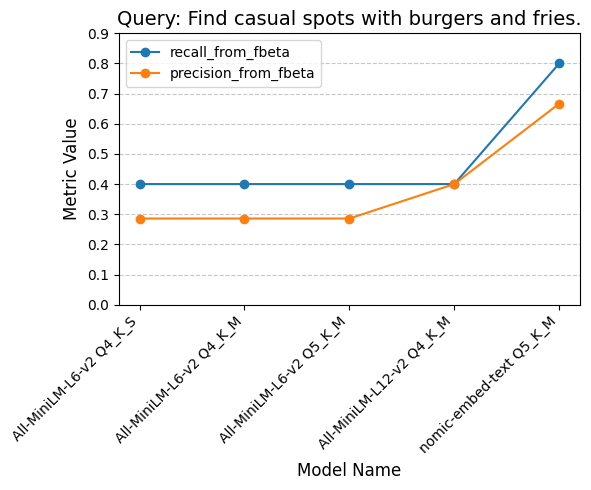

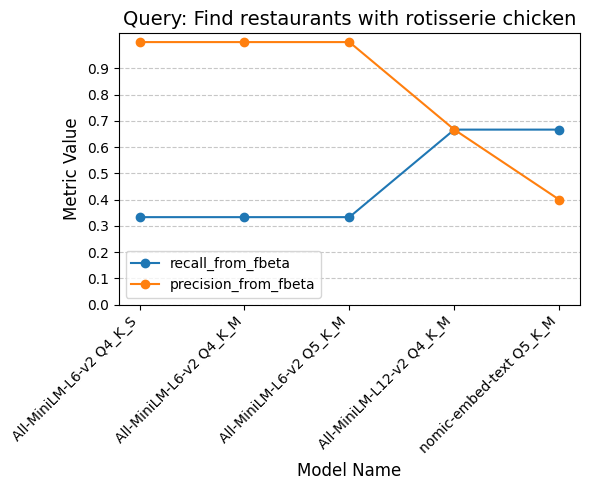

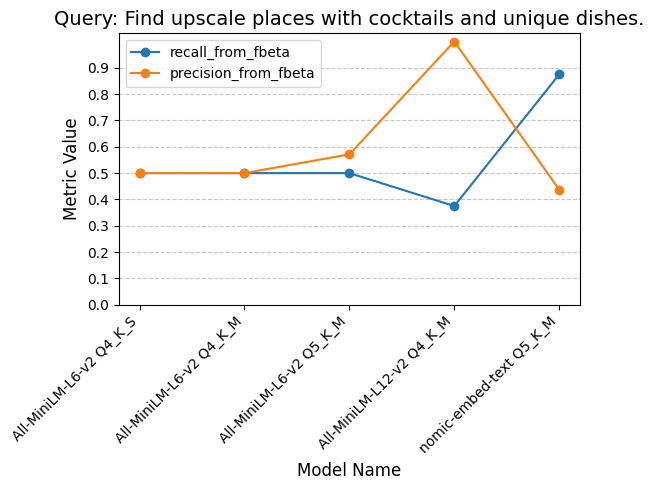

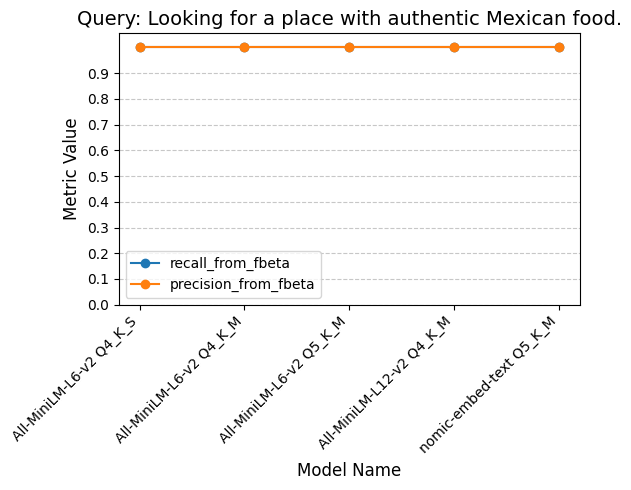

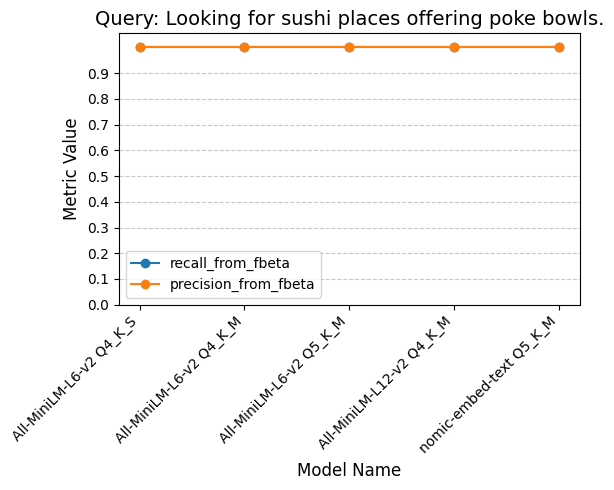

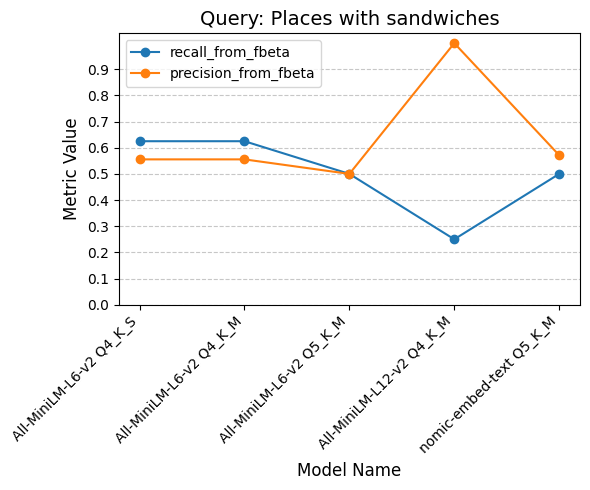

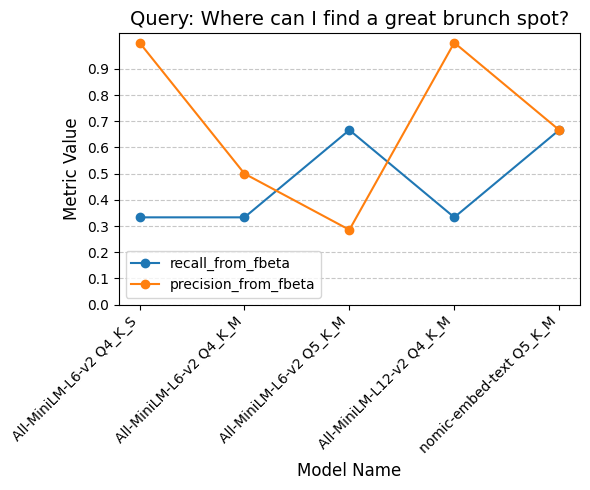

In [177]:
queries = df['query'].unique()
metrics = ['recall_from_fbeta', 'precision_from_fbeta']

for query in queries:
    query_data = df[df['query'] == query]
    
    plt.figure(figsize=(6, 5))
    
    for metric in metrics:
        plt.plot(
            query_data['model_name'],
            query_data[metric],
            marker='o',
            label=metric
        )
    
    plt.title(f"Query: {query}", fontsize=14)
    plt.yticks(np.arange(0, 1, 0.1))
    plt.xlabel("Model Name", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

Examining the performance of each model per query reveals some interesting patterns. While All-MiniLM-L6-v2 Q4_K_S, All-MiniLM-L6-v2 Q4_K_M, and All-MiniLM-L6-v2 Q5_K_M show similar results, All-MiniLM-L12-v2 Q4_K_M appears to lean more towards optimizing for precision at the expense of recall. On the other hand, nomic-embed-text Q5_K_M seems to prioritize recall slightly more than precision.

We can now take the mean F-beta score for each model. This will give us a clearer picture of which model performs better overall, balancing precision and recall according to our chosen F-beta weighting.

In [182]:
avg_metrics = df.groupby("model_name").agg(
    avg_fbeta=("best_fbeta", "mean")
).reset_index()

In [183]:
avg_metrics

,model_name,avg_fbeta
0,All-MiniLM-L12-v2 Q4_K_M,0.644589
1,All-MiniLM-L6-v2 Q4_K_M,0.617367
2,All-MiniLM-L6-v2 Q4_K_S,0.631653
3,All-MiniLM-L6-v2 Q5_K_M,0.609524
4,nomic-embed-text Q5_K_M,0.715801


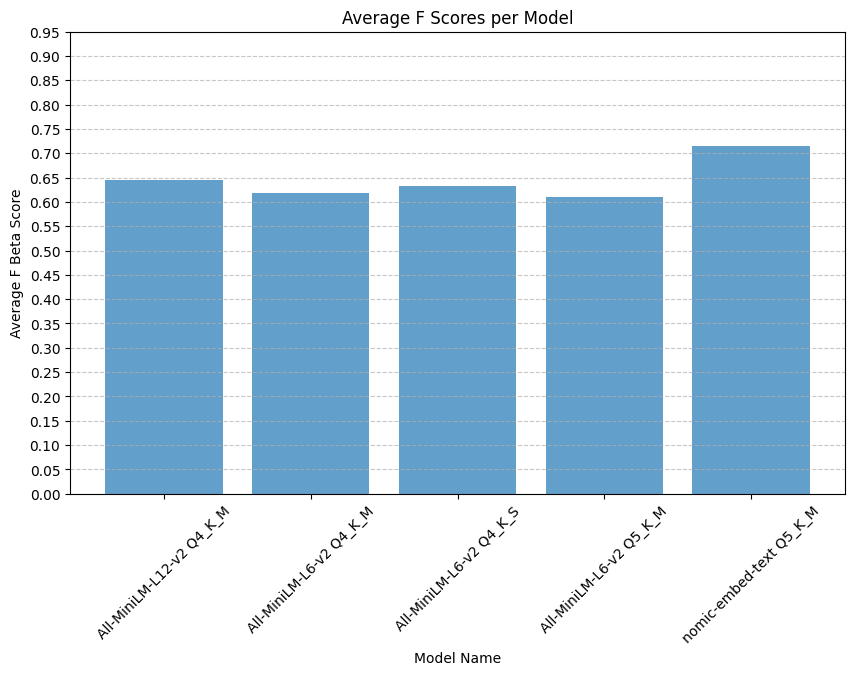

In [184]:
plt.figure(figsize=(10, 6))
plt.bar(avg_metrics["model_name"], avg_metrics["avg_fbeta"], alpha=0.7)
plt.title("Average F Scores per Model")
plt.xlabel("Model Name")
plt.ylabel("Average F Beta Score")
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 1, 0.05))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The `nomic-embed-text` model stands out with the best F-beta score, showcasing a balanced approach between precision and recall. However, our earlier per-query analysis suggests that if we shifted from a balanced F1 to a weighted F-beta (F < 1) emphasizing precision, `All-MiniLM-L12-v2 Q4_K_M` might emerge as the top performer. This highlights how the choice of model ultimately depends on what’s most valuable in your specific context—precision, recall, or balance.

It’s also worth noting that `nomic-embed-text` benefits from a larger context window, which we’re not fully leveraging. Utilizing longer descriptions could further enhance this model’s accuracy and overall performance.

## Conclusion

The goal of this experiment was to compare various embedding models to identify the best performer for our restaurant similarity search. We evaluated restaurant descriptions against a variety of search queries using cosine similarity, determining the most appropriate thresholds for each model and query.

By analyzing the overall performance of each model through their respective F-beta scores, we found that the `nomic-embed-text` model from Nomic AI outperformed the others when using an equally weighted F1 score. Its balanced approach to precision and recall, combined with its larger context window, makes it particularly well-suited for this task, especially if longer descriptions are utilized.

This analysis highlights not only the overall best-performing model but also the trade-offs between precision and recall across different models. It emphasizes the importance of tailoring the choice of model to the specific needs of the application—whether that means prioritizing precision, recall, or maintaining a balance between the two.